In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cf_helper_2 as cf_helper
import matplotlib.pyplot as plt
import importlib
%matplotlib notebook
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
importlib.reload(cf_helper)

<module 'cf_helper_2' from '/Users/julianganzabal/facultad/lab-ml/Sistemas-de-Recomendacion/cf_helper_2.py'>

In [2]:
#df = pd.read_csv('movielens/ml-latest-small/ratings.csv')[['userId','movieId','rating']]
header = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

In [3]:
def get_user_item_matrix(dataframe, userIndexTag, itemIndexTag,ratingTag, test_size_ratio, base_1 = False):
    first = 0
    if base_1:
        first = 1
    n_users = dataframe[userIndexTag].unique().shape[0]
    n_items = dataframe[itemIndexTag].unique().shape[0]
    train_data, test_data = train_test_split(dataframe, test_size=test_size_ratio)

    R = np.zeros((n_users, n_items))
    T = np.zeros((n_users, n_items))
    print(R.shape)

    for index, line in train_data.iterrows():
        R[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]


    for index, line in test_data.iterrows():
        T[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]
    print(T.shape)
    return R,T
R_train, R_test = get_user_item_matrix(df, 'userId','movieId','rating',0.25, base_1 = True)

(943, 1682)
(943, 1682)


In [4]:
R_rated_indexes_train = R_train.nonzero()
R_rated_indexes_test = R_test.nonzero()

In [5]:
I_train = R_train.copy()
T_test = R_test.copy()
I_train[I_train==0] = 0
I_train[I_train!=0] = 1
T_test[T_test==0] = 0
T_test[T_test!=0] = 1

In [6]:
def get_estimated_R(SM, R_tr, R_ts, R_rated_indexes_tr, R_rated_indexes_ts, k = -1, means = 0,divide_by_weights_sum = True, count_diag = False, relevant_rate = 1, perc_points = 100):
    if k==-1:
        R_est = cf_helper.predictions(R_tr, SM, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag, means = means)
    else:
        R_est = cf_helper.predictions_K_neighbours(R_tr, SM, k=k, means = means, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag)
    rmse_tr= cf_helper.rmse(R_tr,R_est)
    rmse_ts = cf_helper.rmse(R_ts, R_est)
    perc = cf_helper.get_percentiles(R_ts, R_est, like = relevant_rate, points = perc_points, number_of_random_items = 500)
    print(rmse_tr,rmse_ts)
    return R_est, perc, rmse_ts

In [7]:
perc_points = 100
relevant_rate = 5

In [8]:
SM_pearson2, user_means2 = cf_helper.getPearsonSimilarityMatrix_non_zeros(R_train)

In [9]:
SM_jaccard, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='jaccard_with_negatives')
SM_pearson, user_means = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='pearson')
SM_cosine, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='cosine')

In [10]:
R_est_pearson2, perc_pearson2, rmse_pearson2 = get_estimated_R(SM_pearson2, R_train, R_test, R_rated_indexes_train, 
                                                               R_rated_indexes_test, 
                                                               means = user_means2, perc_points = perc_points, relevant_rate = relevant_rate)

1.91495883673 1.95547461573


In [11]:
R_est_pearson, perc_pearson, rmse_pearson = get_estimated_R(SM_pearson, R_train, R_test, R_rated_indexes_train, 
                                                            R_rated_indexes_test, means = user_means, 
                                                            perc_points = perc_points, relevant_rate = relevant_rate)

2.90082707037 2.94041925163


In [12]:
R_est_cosine, perc_cosine, rmse_cosine = get_estimated_R(SM_cosine, R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate, means = 0)

3.00587368978 3.03079327328


In [13]:
R_est_jaccard, perc_jaccard, rmse_jaccard = get_estimated_R(SM_jaccard,R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate)

2.96441246543 2.99331452777


In [14]:
mu_train = R_train[R_rated_indexes_train].mean()
percentiles_train_media = cf_helper.get_percentiles(R_test, mu_train*np.ones(R_train.shape), like = 5)

In [15]:
def get_biased_data(R_tr, bias):
    R_tr_b = R_tr.copy()
    R_tr_b[R_tr==0] = bias
    return R_tr_b

In [16]:
R_train_biased = get_biased_data(R_train, mu_train)
SM_biased, user_means_biased = cf_helper.calcultaSimilarityMatrix(R_train_biased, dist_type ='pearson')
R_est_biased, perc_biased, rmse_biased = get_estimated_R(SM_biased, R_train_biased, R_test, R_rated_indexes_train, R_rated_indexes_test, means=user_means_biased, relevant_rate = relevant_rate)

0.228962562889 1.07588903493


/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


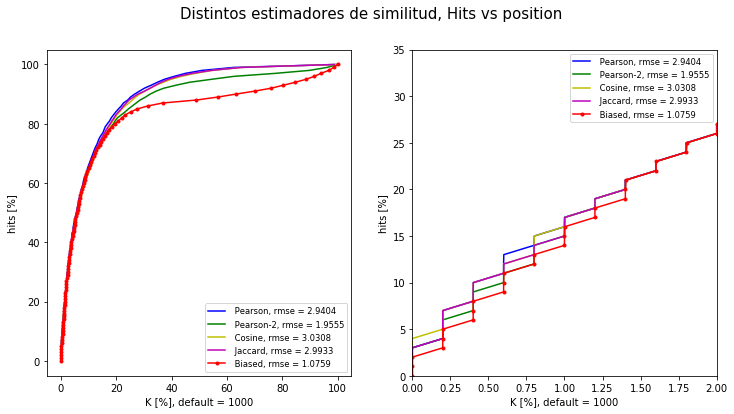

In [17]:
%matplotlib inline
perc_basis_vect = [perc_pearson, perc_pearson2,perc_cosine, perc_jaccard, perc_biased]
rmse_basis_vect = [rmse_pearson, rmse_pearson2,rmse_cosine, rmse_jaccard, rmse_biased]
names_basis_vect = ['Pearson','Pearson-2','Cosine','Jaccard', 'Biased']
cf_helper.plot_percentiles(names_basis_vect, rmse_basis_vect, perc_basis_vect,
                 parameter_name ='', title= 'Distintos estimadores de similitud, Hits vs position',
                 featured_idx = 4, featured_text = 'Biased')


 Ejemplo: si k=2 y hits=30 
 El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)


/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


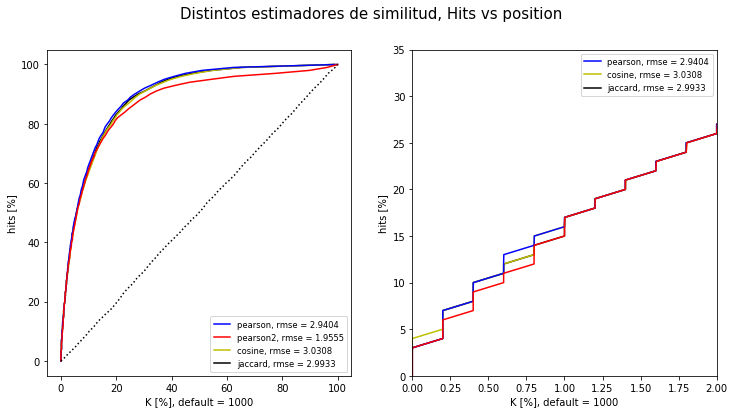

In [18]:
f, ([ax1, ax2]) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(12, 6)) #, figsize=(10, 10)
plt_jaccard, = ax1.plot(*perc_jaccard, color = 'k', label = 'jaccard, rmse = %.4f'%rmse_jaccard)
plt_cosine, = ax1.plot(*perc_cosine, color = 'y', label = 'cosine, rmse = %.4f'%rmse_cosine)
plt_pearson, = ax1.plot(*perc_pearson, color = 'b', label = 'pearson, rmse = %.4f'%rmse_pearson)
plt_pearson2, = ax1.plot(*perc_pearson2, color = 'R', label = 'pearson2, rmse = %.4f'%rmse_pearson2)

ax1.plot(*percentiles_train_media, linestyle = ":", color = 'k')

ax1.legend(handles=[plt_pearson, plt_pearson2, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax1.set_xlabel('K [%], default = 1000')
ax1.set_ylabel('hits [%]')

ax2.plot(*perc_jaccard,  color = 'k')
ax2.plot(*perc_cosine,  color = 'y')
ax2.plot(*perc_pearson, color = 'b')
ax2.plot(*perc_pearson2, color = 'r')

ax2.legend(handles=[plt_pearson, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax2.set_xlabel('K [%], default = 1000')
ax2.set_ylabel('hits [%]')
ax2.set_ylim([0,35])
ax2.set_xlim([0,2])

print('\n Ejemplo: si k=2 y hits=30 \n El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)')
f.suptitle('Distintos estimadores de similitud, Hits vs position', fontsize = 15)
f.show()

# Matrix Factorization

In [19]:
from cf_helper_2 import Matrix_Factorization_baselines_SGD

In [33]:
mu = R_train[R_train.nonzero() ].mean()

In [158]:
# gamma: Learning rate
P, Q, bu, bi, train_rmse_vector, test_rmse_vector, train_accuracy_vector, train_accuracy_vector, gamma, lmbda \
= Matrix_Factorization_baselines_SGD(R_train , R_test, R_rated_indexes_train, R_rated_indexes_test, mu, k=18 
                                     ,sigma = 0.002,
                           gamma= 0.01, lmbda = 0.15, alpha = 0., 
                           n_epochs = 400, error_calc_frec = 1,
                           accuracy_thres = 0, like = 1, dislike = -1)

epoch = -1 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (1.125070, 1.127476)
epoch = 0 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.974719, 0.990081)
epoch = 1 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.950083, 0.971001)
epoch = 2 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.939294, 0.963105)
epoch = 3 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.933177, 0.958844)
epoch = 4 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.929276, 0.956265)
epoch = 5 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.926600, 0.954592)
epoch = 6 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.924669, 0.953452)
epoch = 7 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.923220, 0.952645)
epoch = 8 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.922098, 0.952057)
epoch = 9 accuracy (train, test): (6.1107, 6.1080), rmse (train, test

epoch = 87 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.880797, 0.932905)
epoch = 88 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.880340, 0.932804)
epoch = 89 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.879876, 0.932704)
epoch = 90 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.879403, 0.932604)
epoch = 91 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.878920, 0.932503)
epoch = 92 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.878425, 0.932401)
epoch = 93 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.877916, 0.932298)
epoch = 94 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.877392, 0.932192)
epoch = 95 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.876852, 0.932084)
epoch = 96 accuracy (train, test): (6.1107, 6.1040), rmse (train, test): (0.876295, 0.931973)
epoch = 97 accuracy (train, test): (6.1107, 6.1040), rmse (t

epoch = 174 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.822039, 0.924438)
epoch = 175 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.821503, 0.924412)
epoch = 176 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.820972, 0.924388)
epoch = 177 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.820444, 0.924365)
epoch = 178 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.819921, 0.924343)
epoch = 179 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.819402, 0.924322)
epoch = 180 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.818887, 0.924302)
epoch = 181 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.818376, 0.924283)
epoch = 182 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.817869, 0.924265)
epoch = 183 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.817367, 0.924248)
epoch = 184 accuracy (train, test): (6.1107, 6.108

epoch = 261 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.790352, 0.924274)
epoch = 262 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.790145, 0.924280)
epoch = 263 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.789941, 0.924285)
epoch = 264 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.789739, 0.924291)
epoch = 265 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.789541, 0.924296)
epoch = 266 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.789345, 0.924302)
epoch = 267 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.789151, 0.924307)
epoch = 268 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.788960, 0.924313)
epoch = 269 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.788772, 0.924318)
epoch = 270 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.788586, 0.924324)
epoch = 271 accuracy (train, test): (6.1107, 6.108

epoch = 348 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779623, 0.924676)
epoch = 349 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779557, 0.924680)
epoch = 350 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779492, 0.924683)
epoch = 351 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779427, 0.924687)
epoch = 352 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779364, 0.924691)
epoch = 353 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779301, 0.924694)
epoch = 354 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779239, 0.924698)
epoch = 355 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779178, 0.924702)
epoch = 356 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779117, 0.924705)
epoch = 357 accuracy (train, test): (6.1107, 6.1080), rmse (train, test): (0.779057, 0.924709)
epoch = 358 accuracy (train, test): (6.1107, 6.108

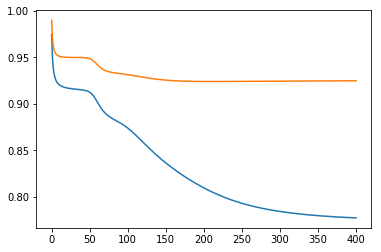

In [159]:
plt.plot(train_rmse_vector)
plt.plot(test_rmse_vector)
plt.show()

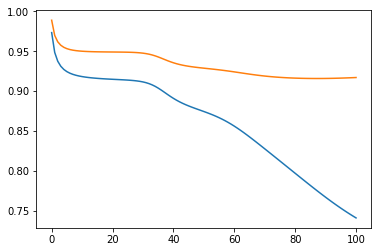

In [153]:
# Lambda = 0.1
plt.plot(train_rmse_vector)
plt.plot(test_rmse_vector)
plt.show()

# SVD

In [160]:
from cf_helper_2 import SVD, rmse, getBaselineEstimates

In [121]:
# k=800, 20
SVD_Predictions = SVD(R_train, k=20)

In [122]:
print('Training:',rmse(R_train, SVD_Predictions))
print('Testing:',rmse(R_test, SVD_Predictions))

Training: 2.38593300816
Testing: 2.71598855321


In [84]:
mu = R_train[R_train.nonzero()].mean()

In [61]:
R_train_norm = (R_train - mu)*(R_train>0)

In [86]:
SVD_Predictions_norm = SVD(R_train_norm, k=20) + mu

In [87]:
print('Training:',rmse(R_train, SVD_Predictions_norm))
print('Testing:',rmse(R_test, SVD_Predictions_norm))

Training: 0.910286953239
Testing: 1.04819270122


In [162]:
bii, bui = getBaselineEstimates(R_train, mu, lambda1 = 0, lambda2 = 0, items_first = True, not_rated = 0)
baseline = mu + bui + bii.T

In [166]:
bii.shape, bui.shape

((943, 1), (1682, 1))

In [89]:
R_train_baseline = (R_train - baseline.T)*(R_train>0)

In [91]:
SVD_Predictions_baseline = SVD(R_train_baseline, k=20) + baseline.T

In [110]:
# k=500, k= 100, K=10, k = 5, k=18
SVD_Predictions_baseline_10 = SVD(R_train_baseline, k=18) + baseline.T
print('Training:',rmse(R_train, SVD_Predictions_baseline_10))
print('Testing:',rmse(R_test, SVD_Predictions_baseline_10))

Training: 0.792122927085
Testing: 0.93954642185
